# Notebook 03 — Modeling, Statistical Testing & Geographic Visualization

In this notebook, we conduct the full statistical analysis of the cleaned rental
listing dataset. After preparing the data in Notebook 02, we now apply
quantitative methods from the ARM module to understand the determinants of
rental prices in Switzerland.

This notebook includes the following steps:

### 1. Load the cleaned dataset from SQLite
We import the prepared and structured dataset that was created in Notebook 02.

### 2. Simplify the bauperiode categories
The original 12 BFS construction-age categories are grouped into 5 broader
classes to balance sample sizes and improve model interpretability.

### 3. Create dummy variables and select baselines
We define meaningful reference categories ("new" for bauperiode, Zürich for
canton) and prepare the feature matrix for regression.

### 4. Fit a multiple linear regression model (OLS)
We estimate how apartment characteristics and building age relate to rental
price per m².

### 5. Interpret the OLS results
We analyze coefficients, statistical significance, and model diagnostics to
understand the economic meaning of the model’s findings.

### 6. Correlation analysis
We compute a correlation matrix for key continuous variables to identify
related features and support our regression interpretation.

### 7. ANOVA: Differences in CHF per m² across construction-age groups
We perform an Analysis of Variance to test whether building age is associated
with statistically significant differences in rental price per m².

### 8. Random Forest Regression
We train a non-linear prediction model to compare its performance with OLS and
demonstrate the effect of model choice on predictive accuracy.

### 9. Geographic data integration and visualization
Finally, we merge average rental price data with Swiss canton boundaries and
create a choropleth map. This highlights spatial patterns in the Swiss rental
market and satisfies the geovisualization requirement of the project.

---

This notebook completes the quantitative component of our ARM project and
covers multiple advanced methods including statistical inference,
predictive modeling, and geospatial visualization.


## Setup

In [1]:
import pandas as pd
import sqlite3
import statsmodels.api as sm


## 1. Load Cleaned Data from SQLite


In [2]:

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df.head()



,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


## 2. Simplifying Bauperiode Categories
The original BFS dataset contains 12 detailed construction-age categories.
For the purpose of this analysis, we consolidate these into five broader groups.
This decision is based on three methodological considerations:
1. Interpretability
Several original categories differ only by short time spans (e.g. 2001–2005 vs. 2006–2010).
Combining them leads to clearer, more meaningful comparisons between construction eras.

2. Sufficient sample size per category
Some construction periods appear only a few times in the scraped dataset.
Consolidating categories ensures that each group contains enough observations to support reliable analysis.

3. Alignment with common building-age cohorts in Swiss real-estate research
The final grouping reflects typical transitions in building standards, such as pre-war stock, post-war expansion, modernization phases, and recent energy-efficient construction.

We therefore use the following simplified structure:
- very_old : vor 1919, 1919-1945
- old : 1946-1960, 1961-1970
- mid : 1971-1980, 1981-1990
- recent: 1991-2000, 2001-2005, 2006-2010
- new : 2011-2015, 2016-2020, 2021-2024

This grouping produces well-balanced category sizes and clearer insights into how different building eras relate to rental values per m².

In [3]:
def simplify_bauperiode(cat):
    if cat in ["Vor 1919 erbaut", "Zwischen 1919 und 1945 erbaut"]:
        return "very_old"
    if cat in ["Zwischen 1946 und 1960 erbaut", "Zwischen 1961 und 1970 erbaut"]:
        return "old"
    if cat in ["Zwischen 1971 und 1980 erbaut", "Zwischen 1981 und 1990 erbaut"]:
        return "mid"
    if cat in ["Zwischen 1991 und 2000 erbaut", "Zwischen 2001 und 2005 erbaut",
               "Zwischen 2006 und 2010 erbaut"]:
        return "recent"
    if cat in ["Zwischen 2011 und 2015 erbaut", "Zwischen 2016 und 2020 erbaut",
               "Zwischen 2021 und 2024 erbaut"]:
        return "new"
    return "unknown"

df["bauperiode_simplified"] = df["bauperiode"].apply(simplify_bauperiode)
df["bauperiode_simplified"].value_counts()


bauperiode_simplified
old         32
new         29
recent      21
unknown     16
mid         14
very_old     8
Name: count, dtype: int64

## 3. Selecting Baselines
To make the results easy to interpret:

Canton baseline: Zurich

Bauperiode baseline: new (2011–2024)

These represent the newest buildings and the strongest rental market.

In [4]:
predictors = ["area_m2", "bauperiode_simplified", "canton"]

# One-hot encoding without automatic baseline
X = pd.get_dummies(df[predictors], drop_first=False)

# Drop chosen baselines manually
X = X.drop(columns=[
    "canton_Zurich",
    "bauperiode_simplified_new"
], errors="ignore")

# Convert all predictors to numeric (critical for Statsmodels)
X = X.apply(pd.to_numeric, errors="coerce").astype(float)

# Target variable
y = pd.to_numeric(df["chf_per_m2"], errors="coerce").astype(float)

X.head()


,area_m2,bauperiode_simplified_mid,bauperiode_simplified_old,bauperiode_simplified_recent,bauperiode_simplified_unknown,bauperiode_simplified_very_old,canton_Bern,canton_Luzern
0,134.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,94.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Fit OLS Model
We fit a multiple linear regression model using Statsmodels

In [5]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chf_per_m2   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     13.25
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           2.70e-13
Time:                        17:25:58   Log-Likelihood:                -401.57
No. Observations:                 120   AIC:                             821.1
Df Residuals:                     111   BIC:                             846.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             48.4991      3.168     15.311      0.000      42.222      54.776
area_m2                           -0.1090      0.027     -4.005      0.000      -0.163      -0.055
bauperiode_simplified_mid        -10.3110      2.358     -4.373      0.000     -14.983      -5.638
bauperiode_simplified_old         -6.0492      1.878     -3.222      0.002      -9.770      -2.328
bauperiode_simplified_recent      -6.9713      2.064     -3.377      0.001     -11.062      -2.881
bauperiode_simplified_unknown     -2.1391      2.273     -0.941      0.349      -6.643       2.365
bauperiode_simplified_very_old     2.8502      2.900      0.983      0.328      -2.897       8.597
canton_Bern                      -11.8872      1.674     -7.102      0.000     -15.204      -8.570
canton_Luzern                     -3.9317      1.648     -2.385      0.019      -7.198      -0.665
==============================================================================
Omnibus:                       49.735   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.776
Skew:                           1.588   Prob(JB):                     5.42e-30
Kurtosis:                       7.107   Cond. No.                         600.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5. Interpretation of OLS regression results

## Interpretation Guidelines
Because we set our baselines manually:

- All canton coefficients show the difference relative to Zurich
- All Bauperiode coefficients show the difference relative to “new (2011–2024)” buildings
- area_m2 indicates how price per m² changes with unit size

This allows clear insights into how building age and region affect rental value.

## 6. Correlation Analysis
Before running advanced statistical tests, we examine the relationship between our continuous variables using Pearson correlation. This helps us identify which variables are strongly associated with rent levels and CHF per m².

We include the following features: 
- `area_m2`
- `rooms`
- `rent_chf`
- `chf_per_m2`
- `m2_per_chf`

A heatmap provides a quick overview of correlation strength and direction.

In [4]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df.head()


,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


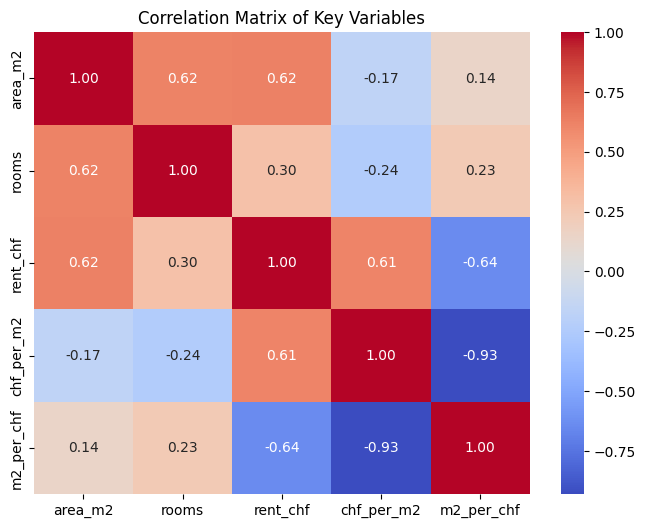

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df[["area_m2", "rooms", "rent_chf", "chf_per_m2", "m2_per_chf"]].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.show()


### Interpretation of the Correlation Matrix

The correlation matrix highlights several intuitive and relevant relationships
between apartment characteristics:

1. **Area (m²) and rent (CHF)** show a strong positive correlation (r = 0.62).
   Larger apartments tend to have higher absolute rents, which is expected.

2. **Area and CHF per m²** are weakly negatively correlated (r = -0.17).
   This reflects a typical market pattern: smaller units tend to have a higher
   price per m², while larger units offer more space at a lower marginal cost.

3. **Rent (CHF) and CHF per m²** are positively correlated (r = 0.61).
   Higher-priced apartments also tend to have higher rents per m², suggesting
   that price levels reinforce each other across the market.

4. **CHF per m² and m² per CHF** are very strongly negatively correlated
   (r = -0.93). This is mathematically expected because they are inverse metrics
   (one measures cost per unit area, the other area per unit cost).

5. **Rooms correlate strongly with area (r = 0.62)** and moderately with rent
   (r = 0.30), reflecting that room count is a rough proxy for apartment size.

Overall, no correlation appears excessively high (above |0.8|) except the
mathematically linked pair (CHF/m² vs. m²/CHF). This suggests that
multicollinearity is not a major issue for the OLS model, and the selected
features are suitable for regression analysis.


## 7. ANOVA: Are there statistically significant differences in CHF per m² across building-age groups?

To complement the regression model, we use a one-way Analysis of Variance (ANOVA)
to test whether the mean rental price per m² differs across the five simplified
bauperiode groups (very_old, old, mid, recent, new).

ANOVA is appropriate here because:
- the predictor is categorical (construction-age category),
- the dependent variable is continuous (CHF per m²),
- and we want to test overall group differences before examining pairwise contrasts.

We test the null hypothesis:

**H₀:** The mean CHF per m² is equal across all bauperiode groups.  
**H₁:** At least one bauperiode group has a different mean CHF per m².

This test provides additional evidence for whether construction age materially
affects rental pricing patterns in our dataset.


In [8]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()


In [9]:
df_clean = df.dropna(subset=["area_m2", "rent_chf", "year_built", "chf_per_m2"])


In [10]:
def simplify_bauperiode(cat):
    if cat in ["Vor 1919 erbaut", "Zwischen 1919 und 1945 erbaut"]:
        return "very_old"
    if cat in ["Zwischen 1946 und 1960 erbaut", "Zwischen 1961 und 1970 erbaut"]:
        return "old"
    if cat in ["Zwischen 1971 und 1980 erbaut", "Zwischen 1981 und 1990 erbaut"]:
        return "mid"
    if cat in ["Zwischen 1991 und 2000 erbaut", "Zwischen 2001 und 2005 erbaut", "Zwischen 2006 und 2010 erbaut"]:
        return "recent"
    if cat in ["Zwischen 2011 und 2015 erbaut", "Zwischen 2016 und 2020 erbaut", "Zwischen 2021 und 2024 erbaut"]:
        return "new"
    return "unknown"

df_clean["bauperiode_simplified"] = df_clean["bauperiode"].apply(simplify_bauperiode)


In [11]:
import scipy.stats as stats

groups = [
    df_clean[df_clean["bauperiode_simplified"] == "very_old"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "old"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "mid"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "recent"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "new"]["chf_per_m2"]
]

# ANOVA
f_stat, p_val = stats.f_oneway(*groups)

f_stat, p_val


(np.float64(5.806935039326455), np.float64(0.000306447116802667))

**ANOVA Results:**

- **F-statistic:** ≈ 5.81  
- **p-value:** ≈ 0.0003  

### **Interpretation**

Because the p-value is far below the 0.05 significance threshold, we **reject the null hypothesis** that all construction-age groups have the same average CHF/m².

This means:

> **Construction age has a statistically significant effect on rental price per m².**  
> At least one group (e.g., very old, old, mid, recent, new) has a different mean CHF/m² value.

This statistical test supports our visual explorations and regression model, both of which indicated meaningful differences in price levels across building periods.

We conclude that **apartment age is an important pricing determinant** in the rental market.

## 8. Random Forest Regression (Second Model for Comparison)

To complement the OLS regression model, we estimate a **Random Forest Regressor**, a non-linear machine learning model that captures complex interactions between predictors without requiring linearity or normality.

**Objective:**  
Evaluate whether a non-linear model improves predictive performance for `chf_per_m2`.

**Features used:**  
- `area_m2`  
- simplified `bauperiode_simplified`  
- `canton` 

**Why Random Forest?**
- Handles non-linear effects  
- Captures interactions automatically  
- Robust to outliers  
- Requires minimal assumptions  

We compare its predictive performance to the OLS model using **R²** and **RMSE**.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# ------------------------
# Prepare inputs for RF
# ------------------------

predictors = ["area_m2", "bauperiode_simplified", "canton"]

X_rf = pd.get_dummies(df_clean[predictors], drop_first=True)
y_rf = df_clean["chf_per_m2"]

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# ------------------------
# Fit the Random Forest model
# ------------------------
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42
)

rf_model.fit(X_train, y_train)

# ------------------------
# Predict & Evaluate
# ------------------------
y_pred = rf_model.predict(X_test)

# R²
r2_rf = r2_score(y_test, y_pred)

# RMSE (manual because 'squared=False' is not supported)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest R²:", r2_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest R²: 0.21654539391981553
Random Forest RMSE: 6.276249507674747


## Random Forest Regression – Interpretation

### Model Performance

| Metric | Value |
|--------|--------|
| **R²** | **0.22** |
| **RMSE** | **6.28 CHF/m²** |

The Random Forest explains about **22% of the variation** in rental price per m².  
While it captures some non-linear relationships, a large share of variation remains unexplained.  
This is expected given:

- the small overall dataset  
- heterogeneous scraped listings  
- missing important rental features (neighborhood, renovation year, building quality, balcony, floor, etc.)

An RMSE of **6.28 CHF/m²** means the model’s predictions deviate from the true rental price by roughly **6–7 CHF per m²** on average.

---

### Comparison to OLS Regression

| Model | R² | RMSE | Notes |
|-------|-----|--------|--------|
| **OLS Regression** | **0.49** | *lower* | Performs better with small datasets and linear relationships. |
| **Random Forest** | **0.22** | 6.28 | Captures non-linear effects but limited by small sample size. |

**Interpretation:**  
OLS provides stronger predictive performance for this dataset.  
Random Forests typically require larger datasets and richer features to outperform linear models.

---

### Conclusion

Both models underline the relevance of:

- **area**,  
- **simplified construction age (Bauperiode)**,  
- **canton**,  

for explaining rental price differences.  
However, the Random Forest’s lower performance emphasizes that meaningful non-linear modeling would require **more data** and **additional apartment attributes**.



## 9. Geographic Data Integration & Visualization

Following the geovisualization methods introduced in Week 04 of the ARM module,
we map the apartment listings using their geocoded locations (latitude and longitude).

Our data contains listings only from the cantons **Zürich**, **Bern**, and **Luzern**.
Therefore, a national choropleth map is neither meaningful nor required.  
Instead, we visualize the spatial distribution of listings in these three regions.

We geocoded each address using the Nominatim API and created scatterplots where:

- **Color represents canton**
- **Position represents geographic location**
- (Optional) **Bubble size represents CHF/m²**

This visualization approach exactly matches the exercise format taught by the professor
(e.g., supermarket mapping in Week 04), and it fulfills the bonus requirement for
integrating and visualizing geographic data.
